# Plant Pathology 2021 - FGVC8
<img src="https://www.researchgate.net/profile/Seung-Yeol-Lee/publication/282210822/figure/fig1/AS:502574476660736@1496834500292/Comparison-of-leaves-with-apple-blotch-disease-and-apple-blotch-like-symptom-A-H-apple.png" width="400" height="400" />

## Description
Apples are one of the most important temperate fruit crops in the world. Foliar (leaf) diseases pose a major threat to the overall productivity and quality of apple orchards. The current process for disease diagnosis in apple orchards is based on manual scouting by humans, which is time-consuming and expensive.

Although computer vision-based models have shown promise for plant disease identification, there are some limitations that need to be addressed. Large variations in visual symptoms of a single disease across different apple cultivars, or new varieties that originated under cultivation, are major challenges for computer vision-based disease identification. These variations arise from differences in natural and image capturing environments, for example, leaf color and leaf morphology, the age of infected tissues, non-uniform image background, and different light illumination during imaging etc.

## About CVPR
This competition is part of the Fine-Grained Visual Categorization FGVC8 workshop at the Computer Vision and Pattern Recognition Conference CVPR 2021. A panel will review the top submissions for the competition based on the description of the methods provided. From this, a subset may be invited to present their results at the workshop. Attending the workshop is not required to participate in the competition, however only teams that are attending the workshop will be considered to present their work.

In [1]:
!/opt/conda/bin/python3.7 -m pip install --upgrade pip
! pip install -q efficientnet

     |████████████████████████████████| 1.5 MB 2.9 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.0.1
    Uninstalling pip-21.0.1:
      Successfully uninstalled pip-21.0.1


In [2]:
#-------------------
# importing libraries
#-------------------
import tensorflow as tf
from tensorflow.keras import layers
import efficientnet.tfkeras as efn
from sklearn.model_selection import KFold,StratifiedKFold

from kaggle_datasets import KaggleDatasets


import pandas as pd
import numpy as np

import os
import shutil
import csv

import matplotlib.pyplot as plt
import PIL

In [3]:
AUTO = tf.data.experimental.AUTOTUNE

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


In [4]:
GCS_DS_PATH = KaggleDatasets().get_gcs_path()
print(GCS_DS_PATH)

TRAIN_PATH = GCS_DS_PATH + "/train_images/"

train_df = pd.read_csv("../input/plant-pathology-2021-fgvc8/train.csv")

count_dict = train_df.labels.value_counts()
classes = list(count_dict.index)
classes_count = list(count_dict.values)
print("Number of unique labels: ",len(classes))

label2id = {
    'scab': 0,
    'frog_eye_leaf_spot' : 1,
    'rust' : 2,
    'complex' : 3,
    'powdery_mildew' : 4,
}
NUM_CLASSES = len(label2id)    
id2label = dict([(value, key) for key, value in label2id.items()])
train_df["labels"] = train_df["labels"].map(lambda x : [i for i in x.split(" ") if i != "healthy"])
#train_df["labels"] = train_df["labels"].map(lambda x : x.split(" "))
train_df["labels"] = train_df["labels"].map(lambda x : [label2id[i] for i in x])

train_df.head()

gs://kds-044025978685b91e16a595d7ad1cbace6eb4029e76d4f555679a21cd
Number of unique labels:  12


,image,labels
0,800113bb65efe69e.jpg,[]
1,8002cb321f8bfcdf.jpg,"[0, 1, 3]"
2,80070f7fb5e2ccaa.jpg,[0]
3,80077517781fb94f.jpg,[0]
4,800cbf0ff87721f8.jpg,[3]


# Which type of competition is this ? (Multi class or Multi label)
### Many have doubt whether the follwing competition is multi-class or multi-label . Let me clarify this by giving more details.

In the details of data it is mentioned as follows:
> ## **Unhealthy leaves with too many diseases to classify visually will have the complex class, and may also have a subset of the diseases identified.**

Let me show you some labels from `train.csv` file

> **`8002cb321f8bfcdf.jpg     scab frog_eye_leaf_spot complex`**

> **`801f78399a44e7af.jpg     complex`**

> **`80769797ce42f658.jpg      scab frog_eye_leaf_spot`**

You can see that the image with complex label may have some other diseases mentioned. But from data I got **number of unique labels as 12**. So I considered it as **`Multi-Class classification`** and proceded. 

### **In this version I am using MULTI-LABEL CLASSIFICATION**

# Data Visualization

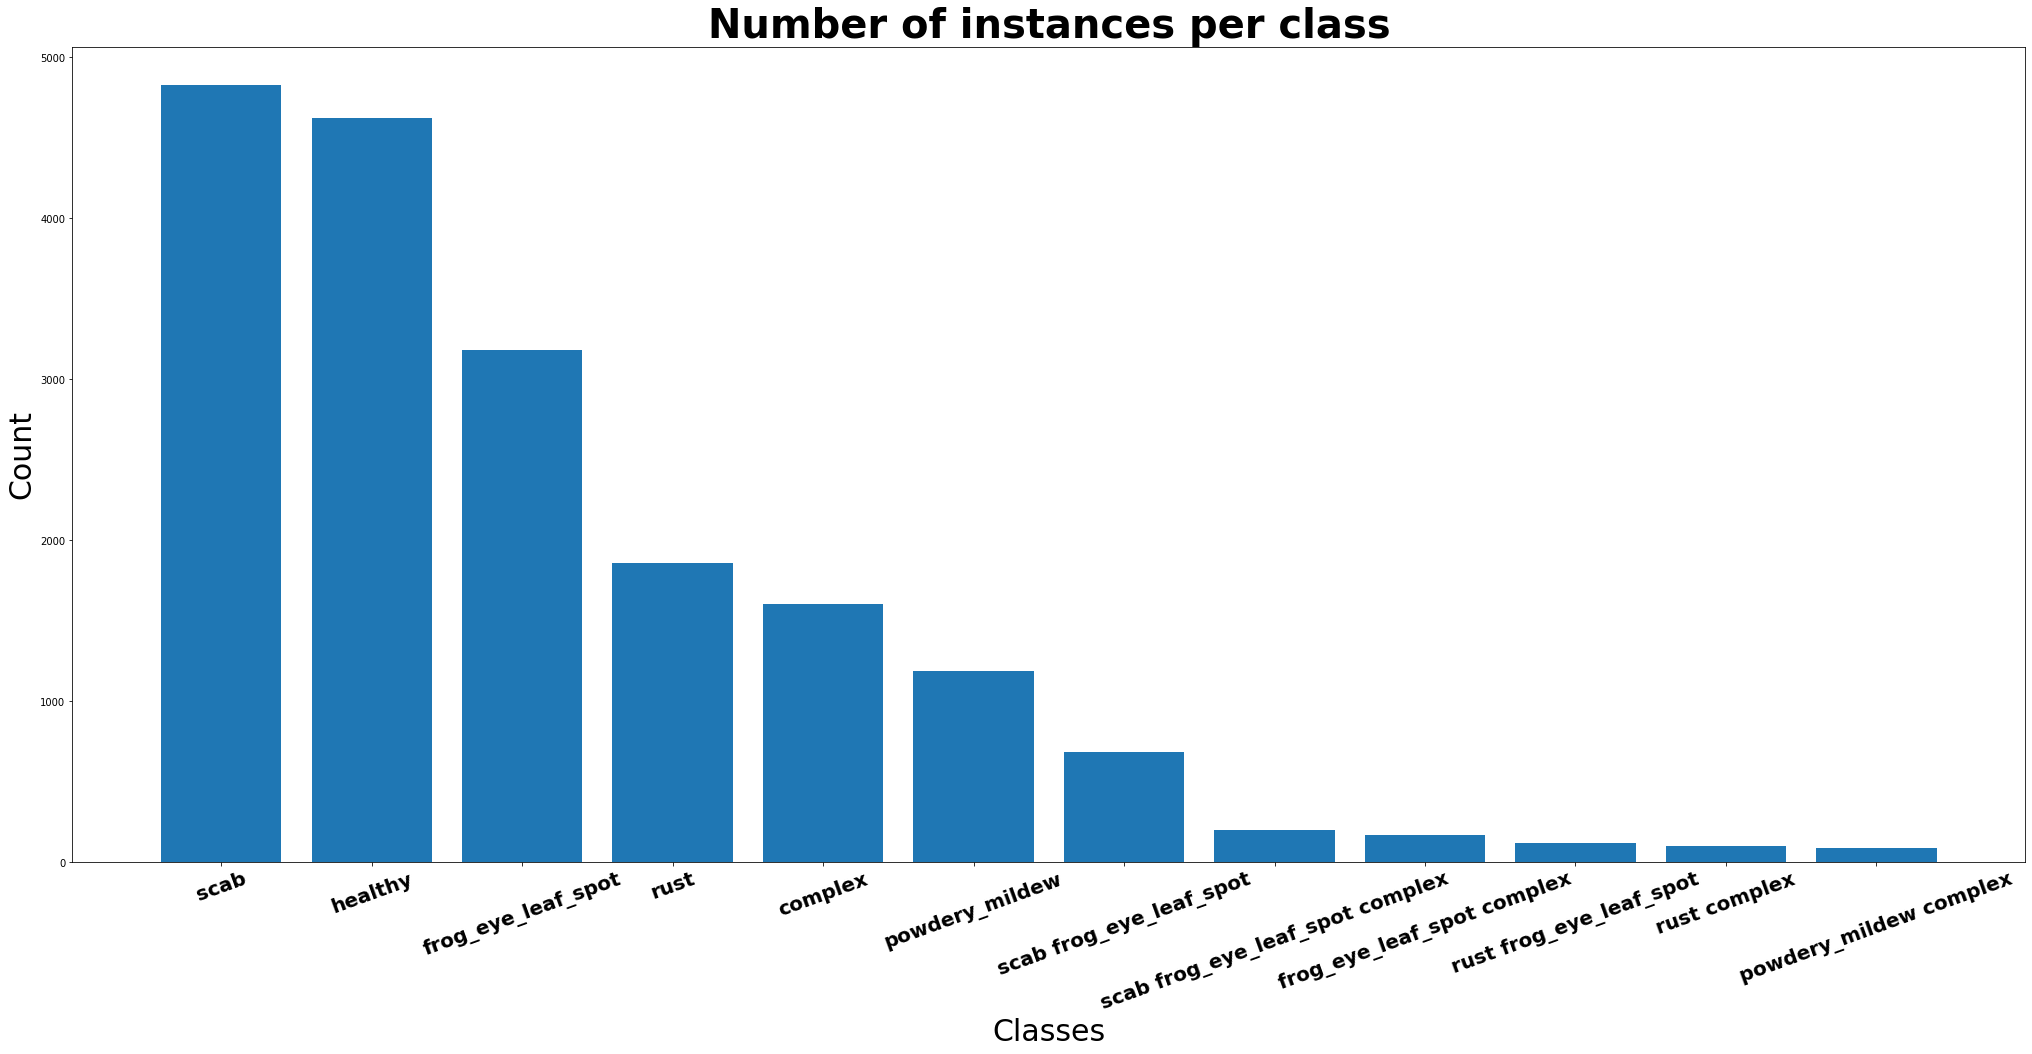

In [5]:
plt.figure(figsize=(35,15))
plt.bar(classes,classes_count)
plt.title("Number of instances per class",fontweight="bold",fontsize=40)
plt.xlabel("Classes",fontsize = 30)
plt.xticks(rotation=20,fontsize = 20,fontweight = "bold")
plt.xticks(fontsize = 20,fontweight = "bold")
plt.ylabel("Count",fontsize=30)
plt.show()

### It's a biased data

Also the image size are varying as follows:
## height = [1728,4032], width = [2592,5184]

In [6]:
#--------------
#initialize constants
#--------------
HEIGHT,WIDTH = 512,512
CHANNELS = 3
BATCH_SIZE = 8 * strategy.num_replicas_in_sync
SEED = 143
AUTO = tf.data.experimental.AUTOTUNE

# Data Preprocessing Functions

In [7]:
def process_img(filepath,label):
    image = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(image, channels=CHANNELS)
    image = tf.image.convert_image_dtype(image, tf.float32) 
    image = tf.image.resize(image, [HEIGHT,WIDTH])
    return image,label


def data_augment(image, label):
    p_spatial = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_rotate = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_pixel_1 = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_pixel_2 = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_pixel_3 = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_crop = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
            
    # Flips
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    if p_spatial > .75:
        image = tf.image.transpose(image)
        
    # Rotates
    if p_rotate > .75:
        image = tf.image.rot90(image, k=3) 
    elif p_rotate > .5:
        image = tf.image.rot90(image, k=2) 
    elif p_rotate > .25:
        image = tf.image.rot90(image, k=1) 
        
    
    if p_pixel_1 >= .4:
        image = tf.image.random_saturation(image, lower=.7, upper=1.3)
    if p_pixel_2 >= .4:
        image = tf.image.random_contrast(image, lower=.8, upper=1.2)
    if p_pixel_3 >= .4:
        image = tf.image.random_brightness(image, max_delta=.1)
        
    
    if p_crop > .7:
        if p_crop > .9:
            image = tf.image.central_crop(image, central_fraction=.7)
        elif p_crop > .8:
            image = tf.image.central_crop(image, central_fraction=.8)
        else:
            image = tf.image.central_crop(image, central_fraction=.9)
    elif p_crop > .4:
        crop_size = tf.random.uniform([], int(HEIGHT*.8), HEIGHT, dtype=tf.int32)
        image = tf.image.random_crop(image, size=[crop_size, crop_size, CHANNELS])
    
    image = tf.image.resize(image, [HEIGHT,WIDTH])
    return image,label

def get_dataset(filenames,labels, training=True):
    dataset = tf.data.Dataset.from_tensor_slices((filenames,labels))
    dataset = dataset.map(process_img,num_parallel_calls=AUTO)
    dataset = dataset.map(data_augment,num_parallel_calls=AUTO)
    dataset = dataset.cache()
    dataset = dataset.repeat()
    if training:
        dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

# Model

In [8]:
def create_model():
    
    pretrained = efn.EfficientNetB7(include_top=False, weights='noisy-student',input_shape=[HEIGHT,WIDTH, 3])
            
    x = pretrained.output
    x = tf.keras.layers.GlobalAveragePooling2D() (x)
    x = tf.keras.layers.Dense(512, activation = "relu") (x)
    x = tf.keras.layers.Dropout(0.3) (x)
    x = tf.keras.layers.Dense(256, activation = "relu") (x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2) (x)
    x = tf.keras.layers.GaussianDropout(0.4) (x)
    outputs = tf.keras.layers.Dense(NUM_CLASSES,activation="sigmoid", dtype='float32')(x)
        
    model = tf.keras.Model(pretrained.input, outputs)
    return model

model = create_model()
#model.summary()

258072576/258068648 [==============================] - 2s 0us/step


# Compiling the Model

In [9]:
import tensorflow_addons as tfa

def compile_model(model, lr=0.001):
    
    optimizer = tf.keras.optimizers.Adam(lr=lr)
    
    loss = tf.keras.losses.BinaryCrossentropy()
    #loss =  tfa.losses.SigmoidFocalCrossEntropy(name="loss",alpha=1.0,gamma=2.0)
    metrics = [
       tfa.metrics.F1Score(num_classes = NUM_CLASSES,average = "macro", name = "f1_score"),
       tf.keras.metrics.BinaryAccuracy(name='acc')
    ]

    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    return model

# Callbacks Function

In [10]:
METRIC = "val_f1_score"

def create_callbacks(kfold,metric = METRIC):
    
    cpk_path = f'./best_model_{kfold}.h5'
    
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath=cpk_path,
        monitor= metric,
        mode='max',
        save_best_only=True,
        verbose=1,
    )

    reducelr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor= metric,
        mode='max',
        factor=0.1,
        patience=3,
        verbose=0
    )

    earlystop = tf.keras.callbacks.EarlyStopping(
        monitor= metric,
        mode='max',
        patience=10, 
        verbose=1
    )
    
    callbacks = [checkpoint, reducelr, earlystop]         
    
    return callbacks

# Training

In [11]:
files_ls = tf.io.gfile.glob(TRAIN_PATH + '*.jpg')
files_df = pd.DataFrame(files_ls, columns = ["filepath"])

labels = np.zeros((len(files_ls),NUM_CLASSES))

for i in range(len(files_ls)):
    labels[i][train_df.iloc[i]["labels"]] = 1
    
print("Total number of Images: ",len(files_ls))

Total number of Images:  18632


In [12]:
EPOCHS = 20
VERBOSE = 1
N_SPLITS = 5

kfold = KFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
history = {}


for fold,(tID,vID) in enumerate(kfold.split(files_ls,labels)):
    tFiles, tLabels = list(files_df.iloc[tID]["filepath"]) , labels[tID]
    vFiles, vLabels = list(files_df.iloc[vID]["filepath"]) , labels[vID]
    print("Number of Training Images: ",len(tID))
    print("Number of Validation Images: ",len(vID))
    
    STEPS_PER_EPOCH  = len(tID)//BATCH_SIZE
    VALID_STEPS = len(vID)//BATCH_SIZE
    
    tf.keras.backend.clear_session()
    
    train_ds = get_dataset(tFiles,tLabels, training = True)
    val_ds = get_dataset(vFiles, vLabels, training = False)
    
    with strategy.scope():
        model = create_model()
        model = compile_model(model, lr=0.0001)
        callbacks = create_callbacks(kfold = fold)
    
        print("------------------Fold - ",fold+1," --------------------------")
        history[fold] = model.fit(
                            train_ds,
                            epochs=EPOCHS,
                            callbacks=callbacks,
                            validation_data = val_ds,
                            verbose=VERBOSE,
                            steps_per_epoch = STEPS_PER_EPOCH,
                            validation_steps=VALID_STEPS
                           )

Number of Training Images:  14905
Number of Validation Images:  3727
------------------Fold -  1  --------------------------
Epoch 1/20
232/232 [==============================] - 1128s 4s/step - loss: 0.4612 - f1_score: 0.2354 - acc: 0.8115 - val_loss: 0.2034 - val_f1_score: 0.6215 - val_acc: 0.9186

Epoch 00001: val_f1_score improved from -inf to 0.62148, saving model to ./best_model_0.h5
Epoch 2/20
232/232 [==============================] - 117s 503ms/step - loss: 0.1918 - f1_score: 0.6448 - acc: 0.9254 - val_loss: 0.1317 - val_f1_score: 0.7135 - val_acc: 0.9456

Epoch 00002: val_f1_score improved from 0.62148 to 0.71354, saving model to ./best_model_0.h5
Epoch 3/20
232/232 [==============================] - 116s 502ms/step - loss: 0.1382 - f1_score: 0.7090 - acc: 0.9459 - val_loss: 0.1085 - val_f1_score: 0.7509 - val_acc: 0.9546

Epoch 00003: val_f1_score improved from 0.71354 to 0.75093, saving model to ./best_model_0.h5
Epoch 4/20
232/232 [==============================] - 116s 50

# History plotting

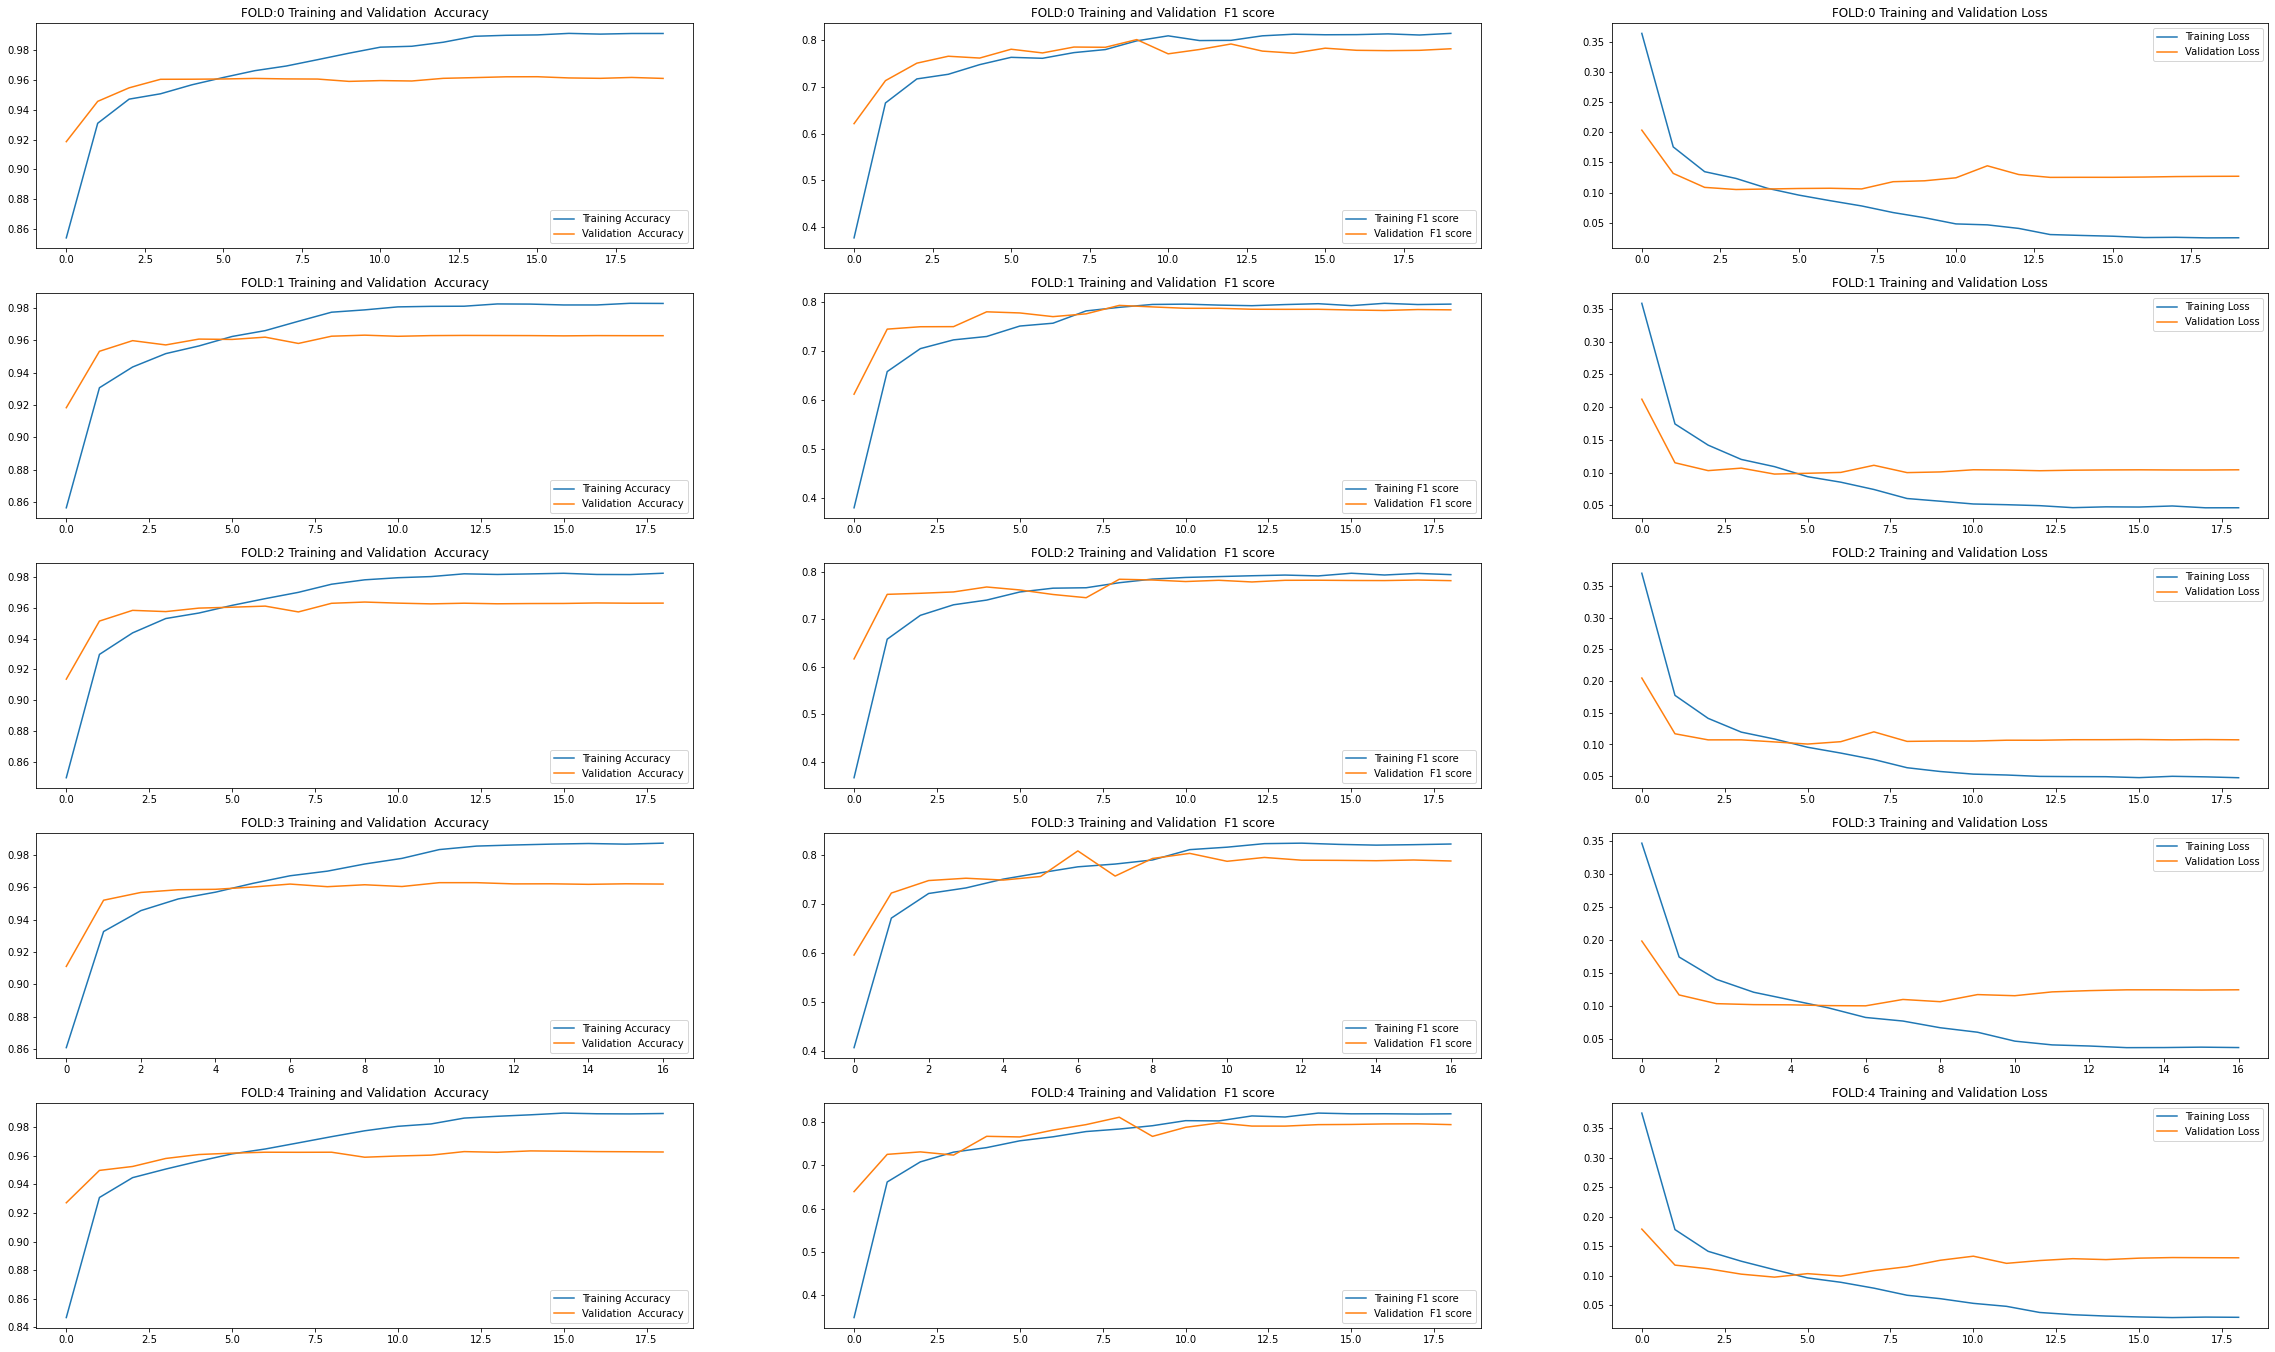

In [13]:
plt.figure(figsize=(8*N_SPLITS,24))

for i in range(N_SPLITS):
    acc = history[i].history['acc']
    val_acc = history[i].history['val_acc']
    f1 = history[i].history['f1_score']
    val_f1 = history[i].history['val_f1_score']
    loss = history[i].history['loss']
    val_loss = history[i].history['val_loss']
    epochs_range = range(len(history[i].history['val_loss'])) 
    
    plt.subplot(N_SPLITS, 3,i*3+1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation  Accuracy')
    plt.legend(loc='lower right')
    plt.title(f'FOLD:{str(i)} Training and Validation  Accuracy')
    
    plt.subplot(N_SPLITS, 3,i*3+2)
    plt.plot(epochs_range, f1, label='Training F1 score')
    plt.plot(epochs_range, val_f1, label='Validation  F1 score')
    plt.legend(loc='lower right')
    plt.title(f'FOLD:{str(i)} Training and Validation  F1 score')
    
    plt.subplot(N_SPLITS, 3, i*3+3)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title(f'FOLD:{str(i)} Training and Validation Loss')

plt.show()

### If you have any doubts or suggestions feel free to contact me.
## Happy coding❤ 